# Oil Price Seasonality and Forecasting                                                 
This notebook investigates seasonality in various energy time series. The main objective is to determine whether their are strong trends and seasonality, the seasonality and trends can be predicted, and their relationship with WTI crude oil prices. Data was downloaded from FRED (Federal Reserve Economic Data) https://fred.stlouisfed.org/

The primary methods used in this experiment are:
- Multiplicative seasonal decomposition
- Linear and non-linear regression
- Multiple regression
- ARIMA

The end of this notebook includes a conclusion of findings.

In [36]:
# File imports
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose

# Package settings
plt.style.use('ggplot')

In [37]:
# Data name mapping (filename, column name)
# Data was downloaded from FRED (Federal Reserve Economic Data): https://fred.stlouisfed.org/
file_names = {
    'data/energy_data/All_Employees_Oil_Gas_Extraction.csv': 'employees',
    'data/energy_data/City_Average_Price_Per_kWH.csv': 'city_average',
    'data/energy_data/Industrial_Production_Utilities_Electric_Gas.csv': 'production',
    'data/energy_data/Manufacturer_New_Orders_Lighting_Equipment.csv': 'orders_lighting',
    'data/energy_data/Manufacturer_New_Orders_Mining_Oil_Gas.csv': 'orders_mining_oil_gas',
    'data/energy_data/WTI_Oil_Prices.csv' : 'oil_price'
}

# Read and combine all files using list comprehension and concat
data = pd.concat([
    pd.read_csv(f).rename(columns={
        'observation_date' : 'observation_date', # Keep the same date column
        f : file_names[f]                        # Rename the column
    }).set_index('observation_date')             # Set the date column as index
    for f in file_names.keys()
], axis=1)

# Clean and adjust the data
data = data.astype(float)
data.index = pd.to_datetime(data.index)
data.drop(data.index[-1], inplace=True)

## Exploratory Data Analysis
To start, a sequence of plots was generated for exploratory data analysis.
1. Time series plots of each variable
2. Frequency distribution of each variable
3. Autocorrelation plots
3. Partial autocorrelation plots
4. Scatterplot matrix of each varable
5. Correlation matrix of each variable

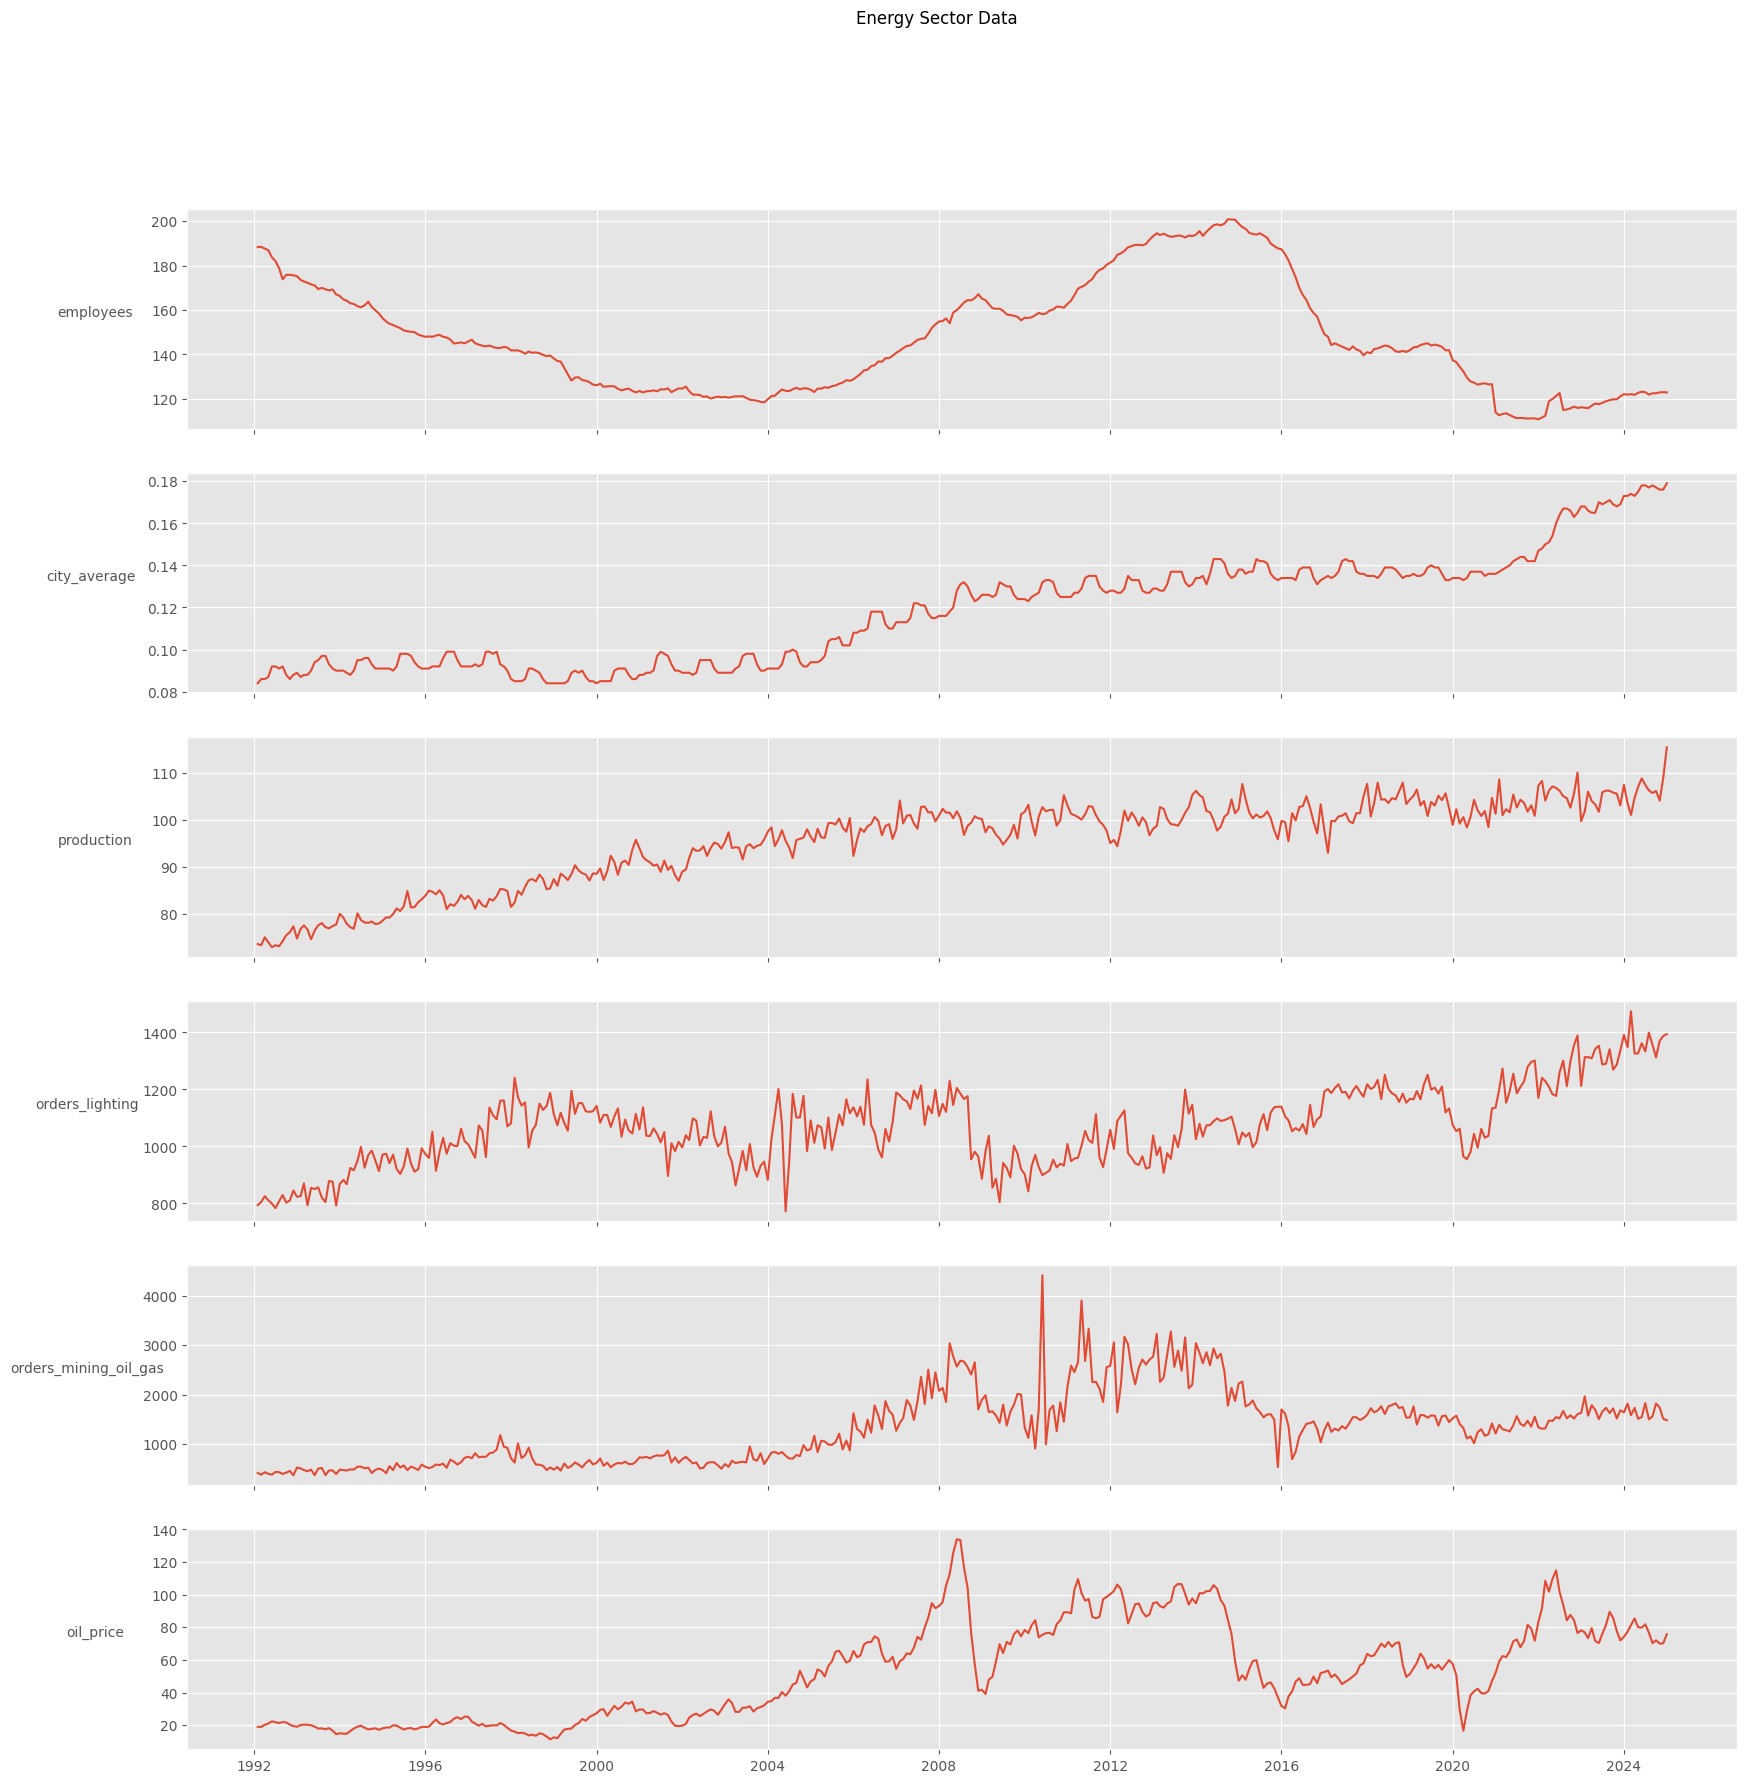

In [38]:
# Data Visualization ==================================================
# Time series plots
N_ROWS, N_COLS = 6, 1
fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(20, 20), sharex=True)
fig.suptitle('Energy Sector Data')

idx = 0
for k, v in file_names.items():
    axes[idx].plot(data[v])
    axes[idx].set_ylabel(v, rotation=0, fontsize=10, labelpad=40)
    idx += 1
plt.show()

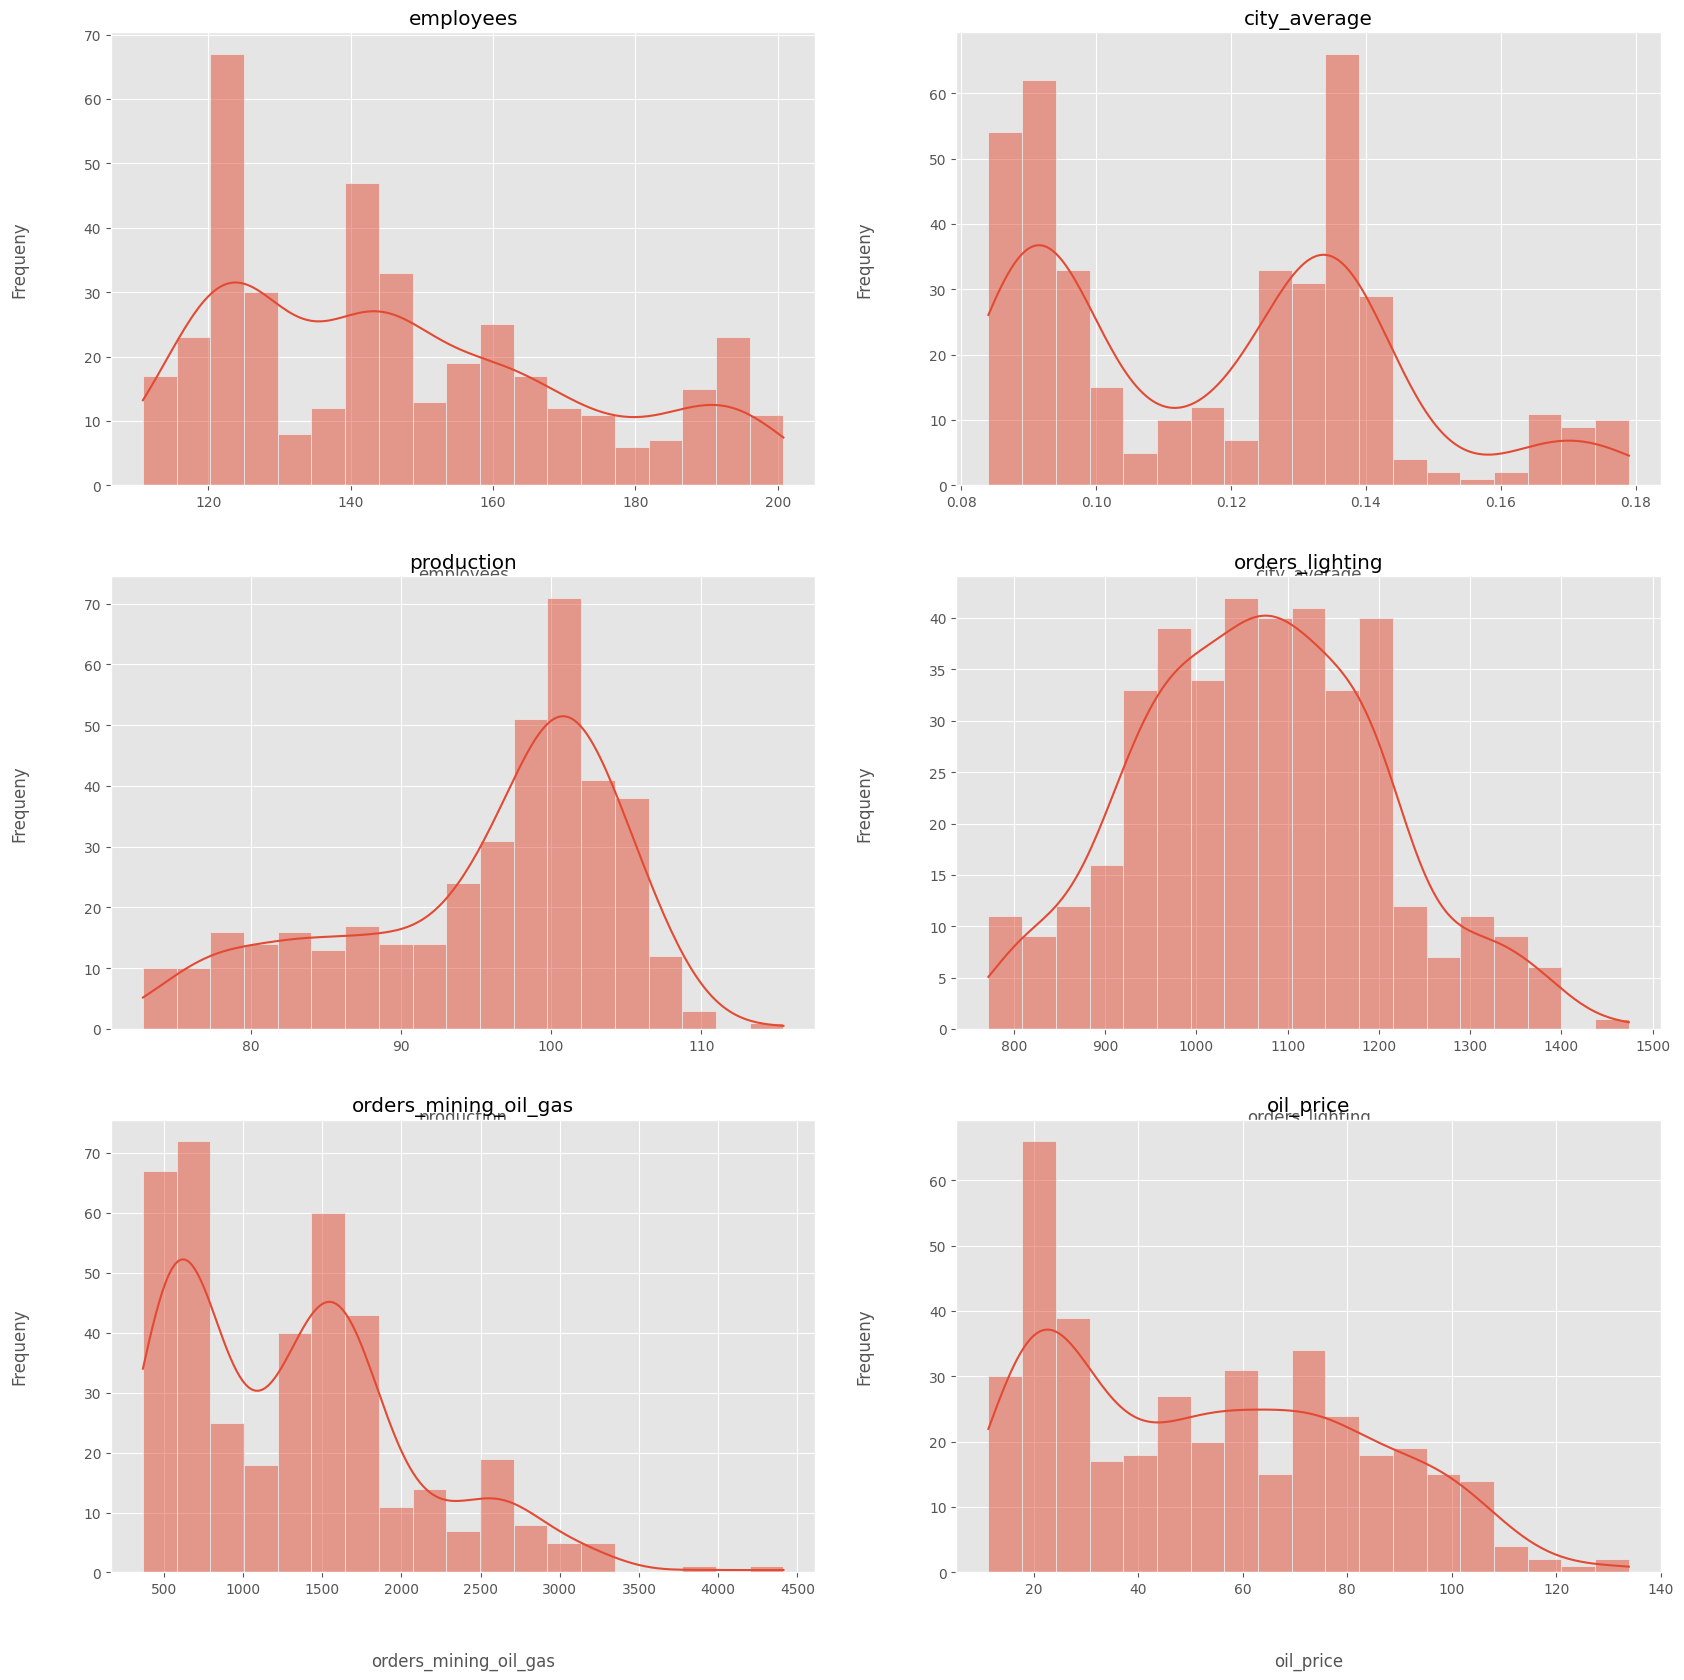

In [39]:
# Distribution plots
N_ROWS, N_COLS, N_BINS = 3, 2, int(math.sqrt(len(data)))
fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(20, 20))

r_idx = 0
c_idx = 0
for k, v in file_names.items():
    sns.histplot(data[v], bins=N_BINS, kde=True, ax=axes[r_idx][c_idx])
    axes[r_idx][c_idx].set_title(v)
    axes[r_idx][c_idx].set_xlabel(v, labelpad=40)
    axes[r_idx][c_idx].set_ylabel('Frequeny', labelpad=40)

    c_idx += 1
    if c_idx == N_COLS:
        c_idx = 0
        r_idx += 1
plt.show()

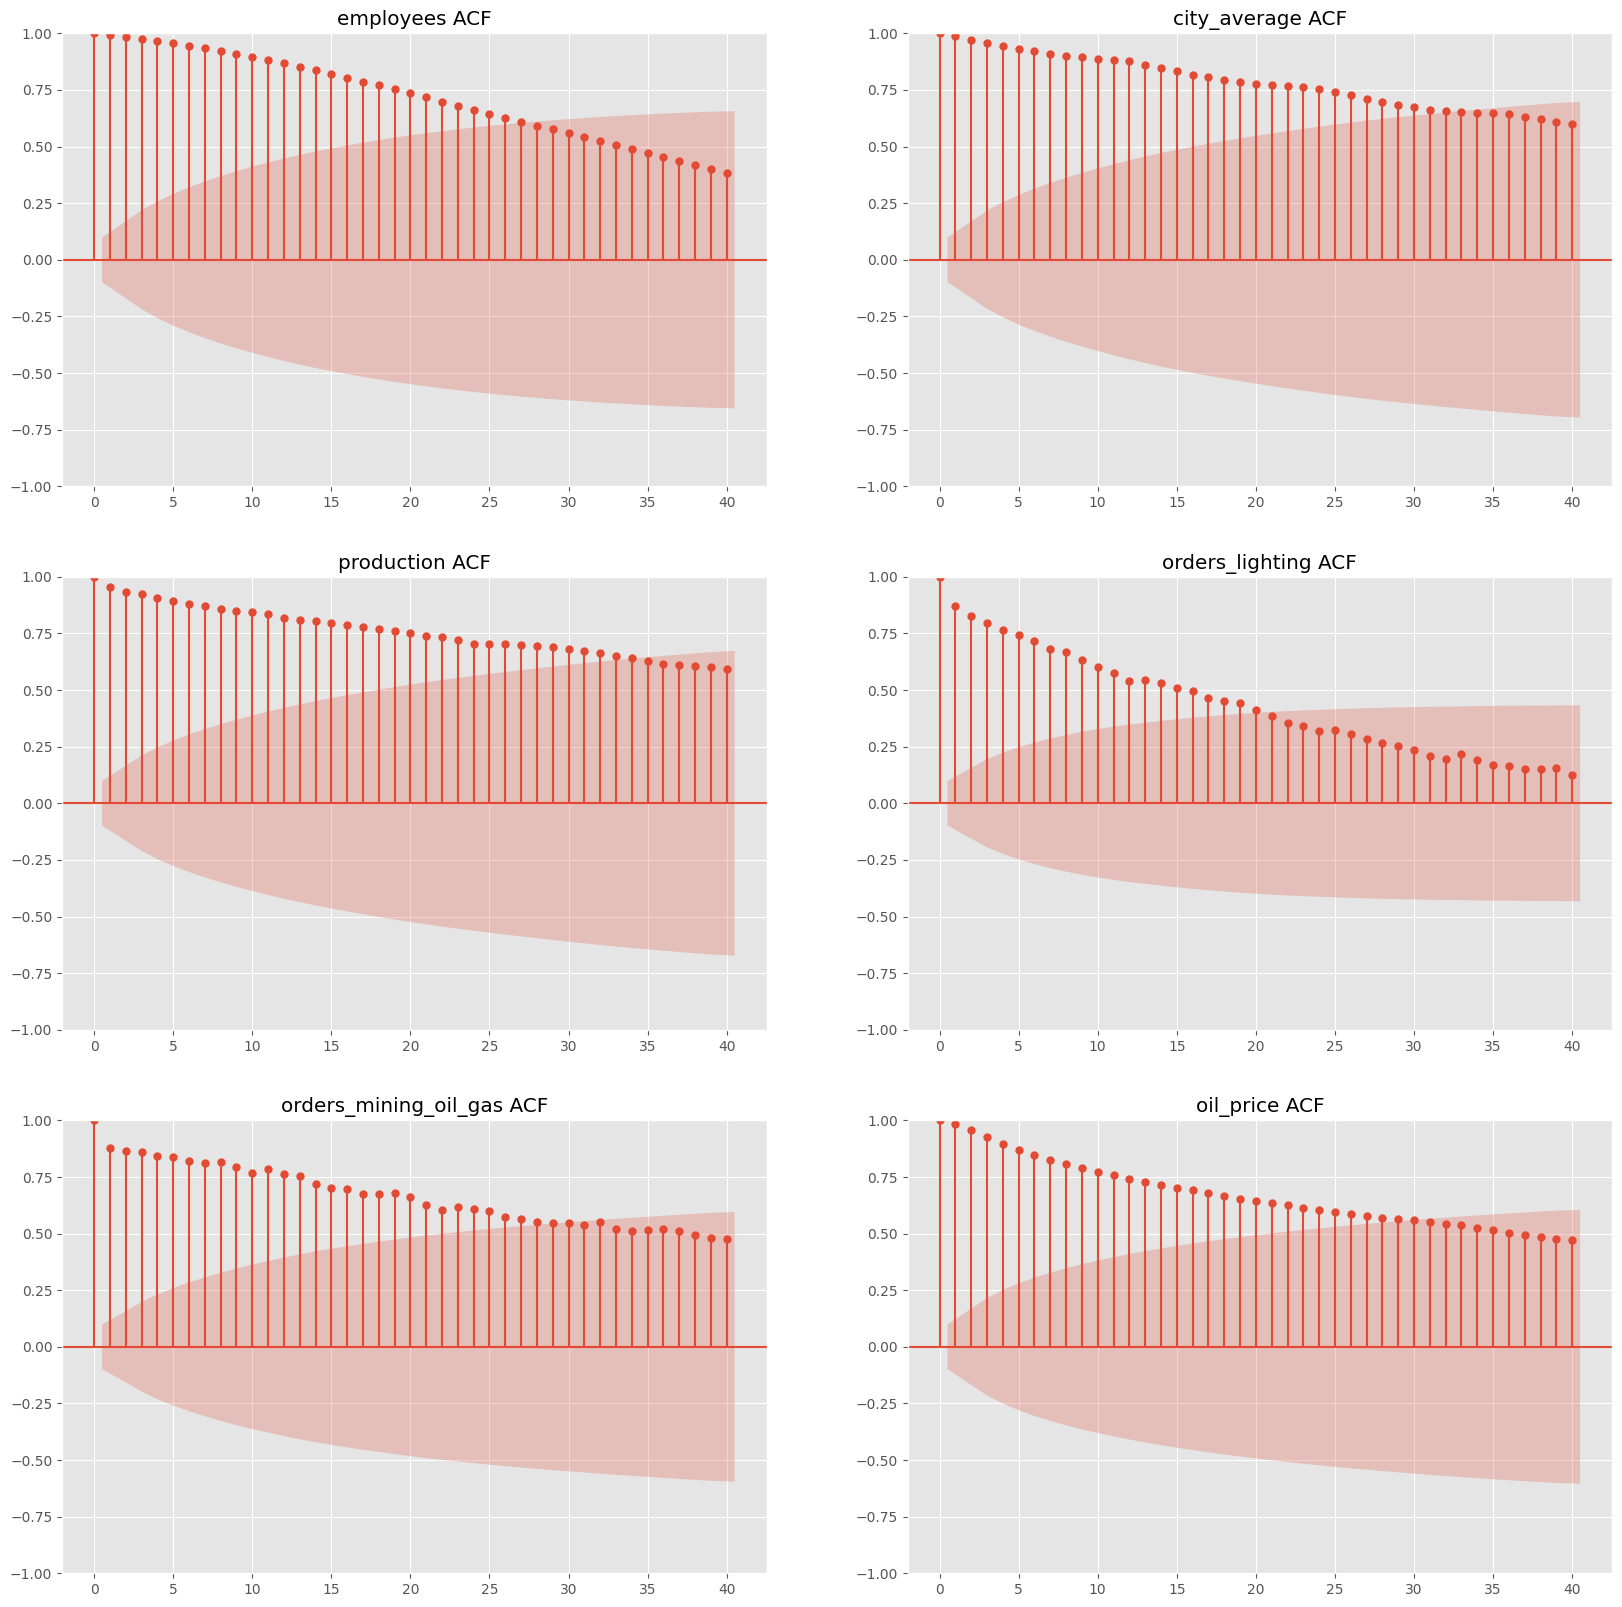

In [40]:
# Autocorrelation plots# 24 lags are used for monthly data (2*m)
N_ROWS, N_COLS = 3, 2
fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS)

# Lags based on data length
N_LAGS = min(40, len(data) // 5)

r_idx = 0
c_idx = 0
for k, v in file_names.items():
    plot_acf(data[v], ax=axes[r_idx][c_idx], title=f"{v} ACF", lags=N_LAGS)
    axes[r_idx][c_idx].figure.set_size_inches(20, 20)

    c_idx += 1
    if c_idx == N_COLS:
        c_idx = 0
        r_idx += 1
plt.show()

ACF Plot Discussion:<br>
From the ACF plots, we can see that each variable has a gradual decline in autocorrelation as the number of lags increase. This indicates that the time series variables are non-stationary an exhibit a trend. In the city_average, production, orders_lighting and orders_mining_oil_gas ACF plots, there is an indication of some seasonality in addition to the trend. 

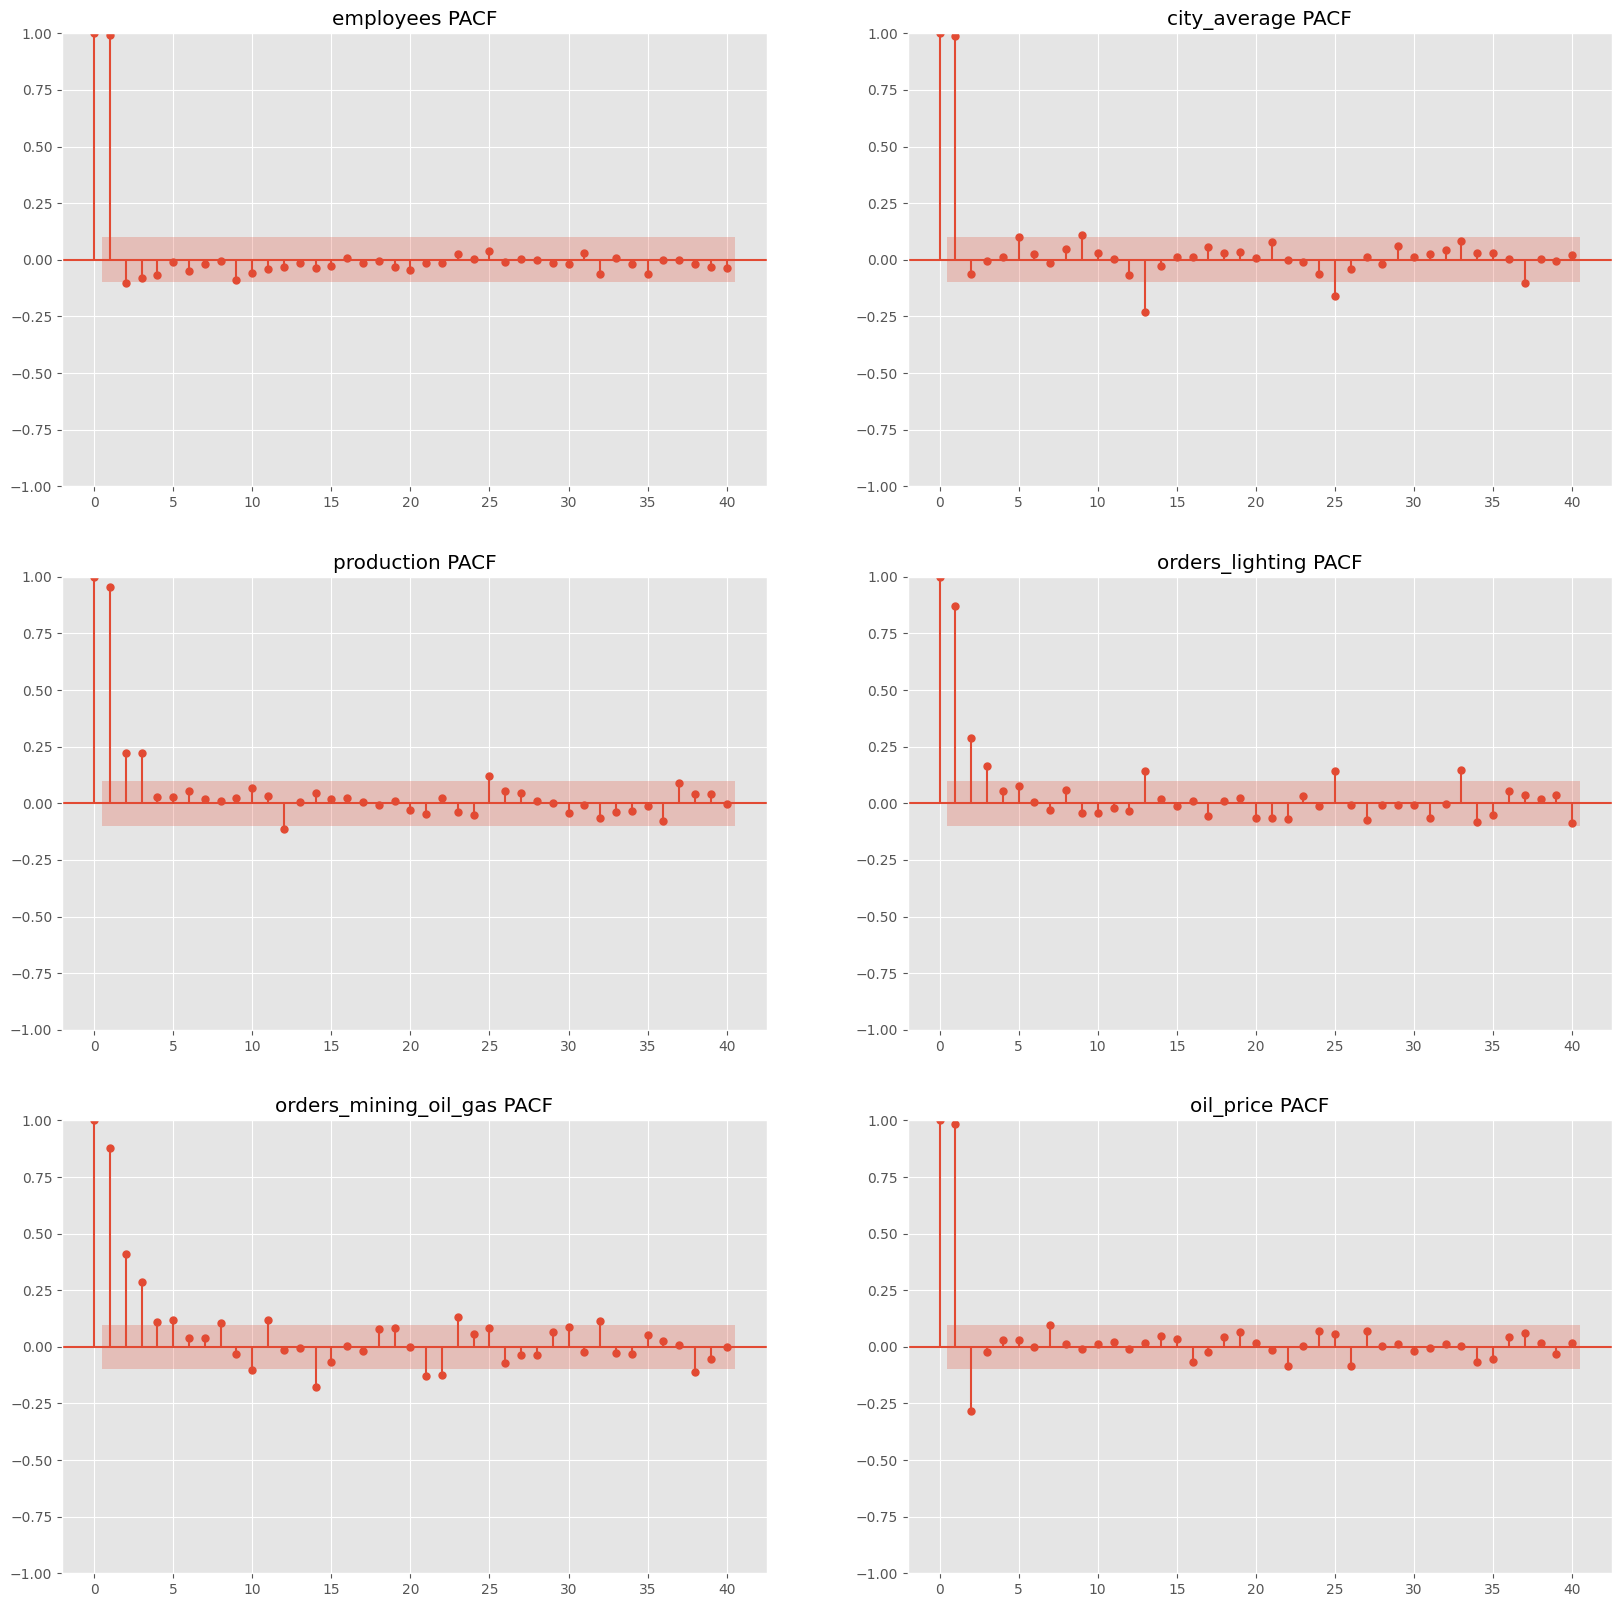

In [41]:
# Partial autocorrelation plots
N_ROWS, N_COLS = 3, 2
fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS)

r_idx = 0
c_idx = 0
for k, v in file_names.items():
    plot_pacf(data[v], ax=axes[r_idx][c_idx], title=f"{v} PACF", lags=N_LAGS)
    axes[r_idx][c_idx].figure.set_size_inches(20, 20)

    c_idx += 1
    if c_idx == N_COLS:
        c_idx = 0
        r_idx += 1
plt.show()

Partial ACF Plot Discussion:
Given the partial ACF plots, we can determine the order of autoregressive models that will be used later in this experiment.
- employees: 1
- city_average: 1 
- production: 3
- orders_lighting: 3
- orders_mining_oil_gas: 5
- oil_price: 2

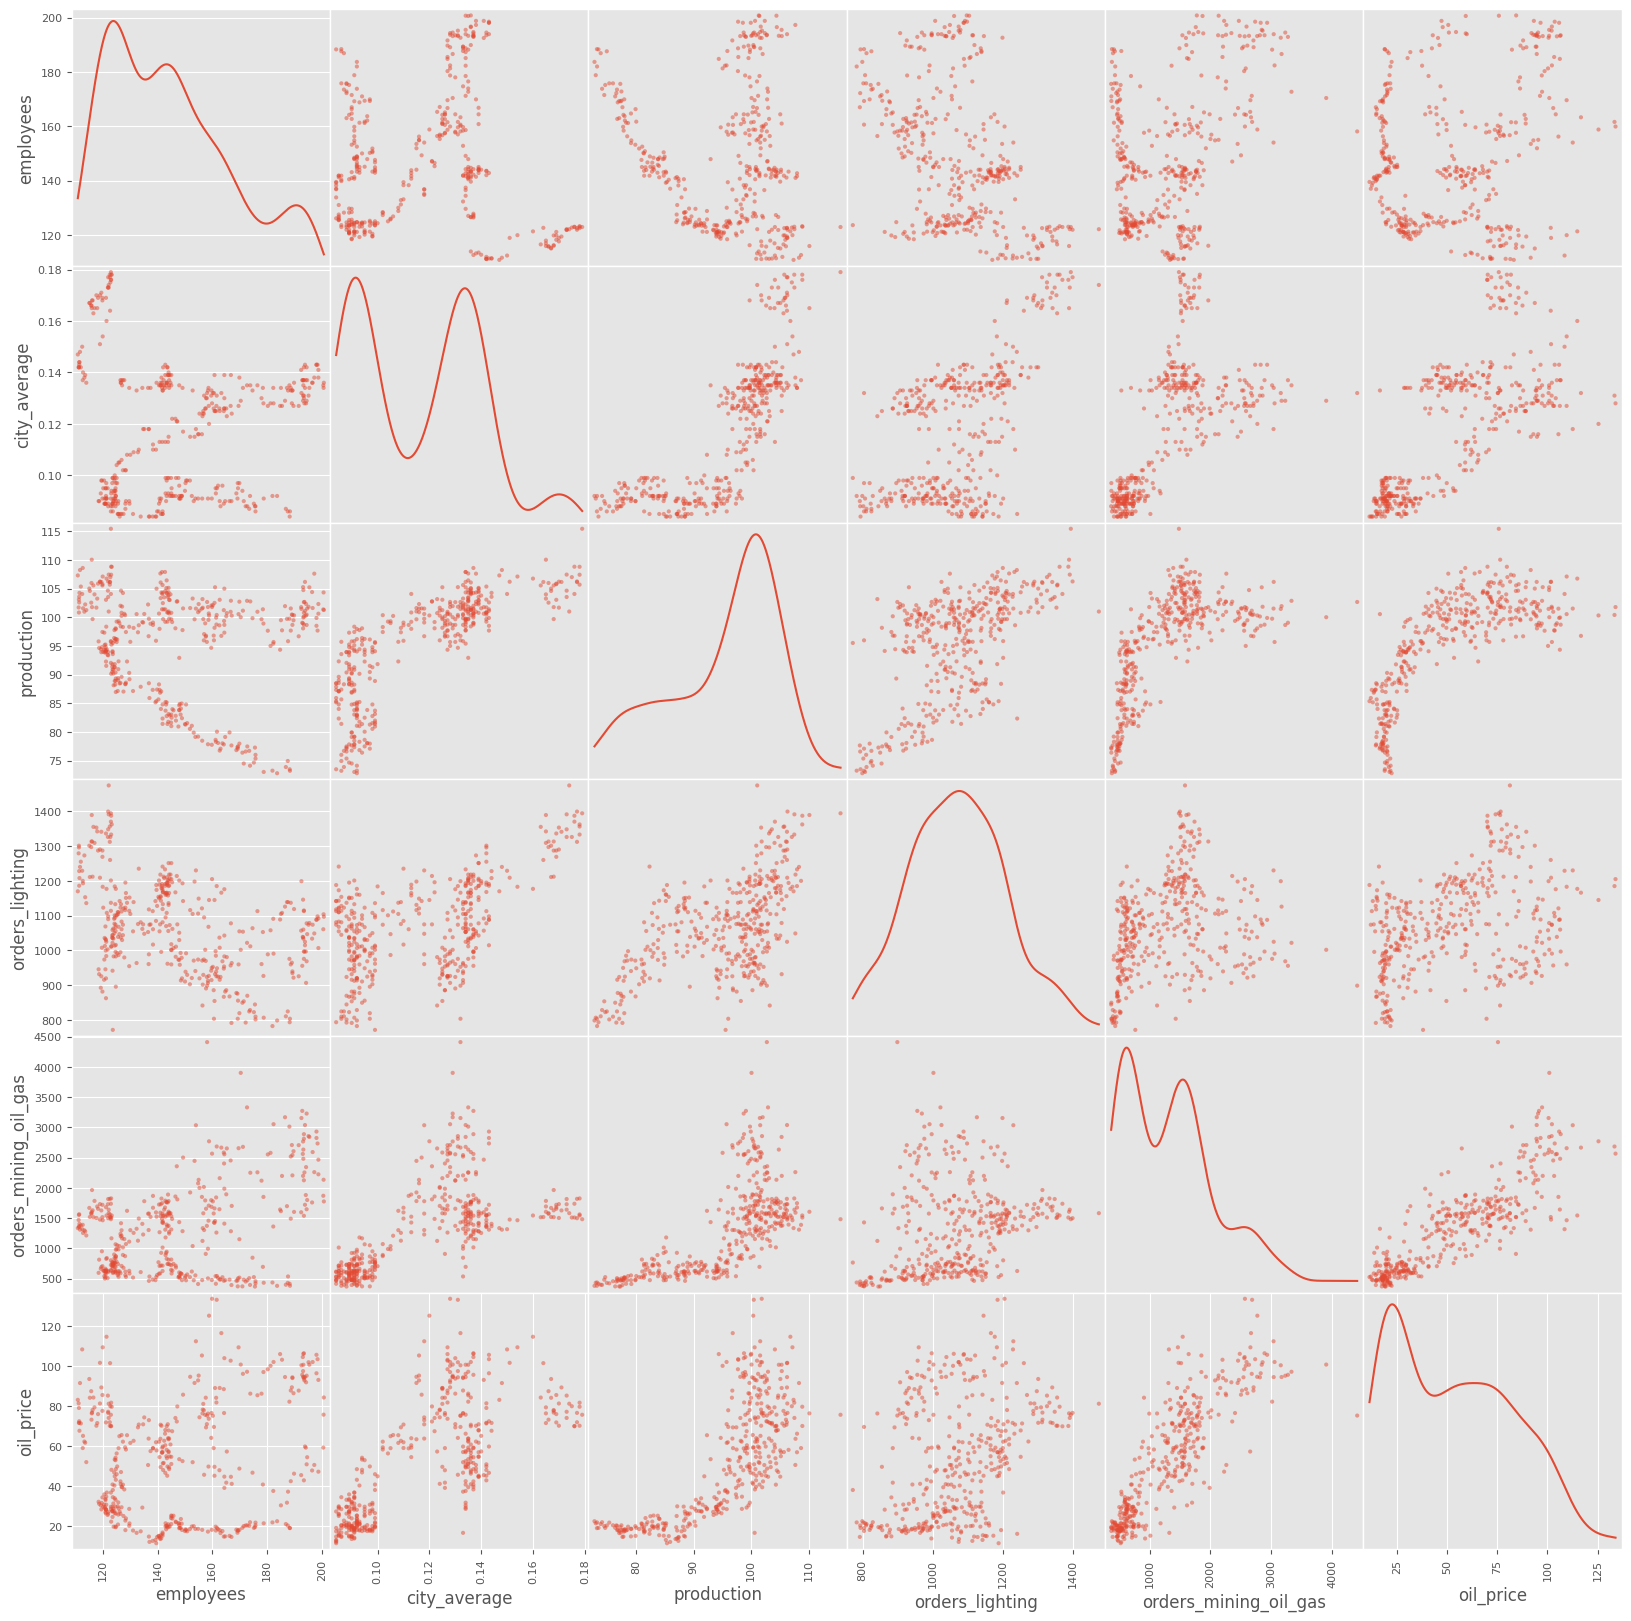

In [42]:
# Scatter plot matrix
pd.plotting.scatter_matrix(data, figsize=(20, 20), diagonal='kde')
plt.show()

Scatterplot Discussion:
The scatter plot shows the relationships among all combinations of two variables. Through visual inspection, there seem to be some pairs of variales that have a relationship. It is important to note that most of the relation pairs show heteroskedasticity.
- oil_price and production (non-linear, heteroskedasticity)
- oil_price and orders_mining_oil_gas (linear, heteroskedasticity)
- orders_mining_oil_gas and production (non-linear, heteroskedasticity)
- city_average and production (non-linear, heteroskedasticity)

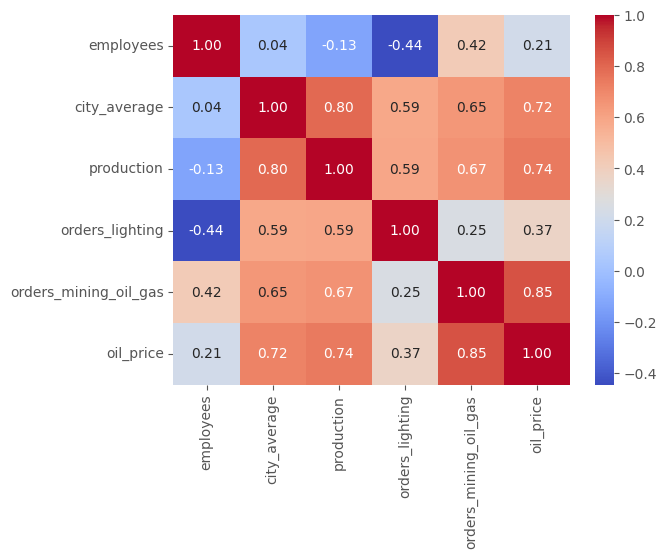

In [43]:
# Correlation matrix
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Correlation Matrix Discussion:<br>
The correlation matrix supports the findings above. Variable pairs that visually show a relationship have strong correlation.

### Formal Autocorrelation Testing
The following formally tests for autocorrelation using the Ljung-Box test (also including the Box-Pierce test). The test calculates the best statistic and p-value for both the LB and BP tests.<br>
Null Hypothesis: Data is independently distributed (no autocorrelation)<br>
Alternative Hypothesis: Data is not independently distributed (autocorrelation)

p-value < 0.05 => reject null hypothesis

In [44]:
P_VALUE_THRESHOLD = 0.05
P_VALUE_COL = "lb_pvalue"

for col in data.columns:
    lb_test = acorr_ljungbox(data[col], lags=N_LAGS, boxpierce=True)

    # Determine if we reject the null hypothesis
    lb_test['reject_null'] = np.where(lb_test[P_VALUE_COL] < P_VALUE_THRESHOLD, True, False)

    # Determine if there are any non-rejections
    if lb_test['reject_null'].any() is False:
        print(f"Test Results ({col}): \n{lb_test}")
    else:
        print(f"Reject the null hypothesis for {col}: autocorrelation")

Reject the null hypothesis for employees: autocorrelation
Reject the null hypothesis for city_average: autocorrelation
Reject the null hypothesis for production: autocorrelation
Reject the null hypothesis for orders_lighting: autocorrelation
Reject the null hypothesis for orders_mining_oil_gas: autocorrelation
Reject the null hypothesis for oil_price: autocorrelation


### Formal Seasonality and Trend Decomposition
The following decomposes the time series data into their respective trend, seasonal, and residual components using the multiplicative decomposition method.<br>

In [45]:
for col in data.columns:
    decomposed_data = seasonal_decompose(data[col], model='multiplicative')

    # Calculate the strength of the seasonal and trend components
    F_t = max(0, 1 - (np.var(decomposed_data.resid) / np.var(decomposed_data.trend + decomposed_data.resid)))
    F_s = max(0, 1 - (np.var(decomposed_data.resid) / np.var(decomposed_data.seasonal + decomposed_data.resid)))

    print(f"{col} => Trend: {round(F_t, 6)} | Seasonal: {round(F_s, 6)}")

employees => Trend: 1.0 | Seasonal: 0.014201
city_average => Trend: 0.829148 | Seasonal: 0.834402
production => Trend: 0.999995 | Seasonal: 0.007185
orders_lighting => Trend: 1.0 | Seasonal: 0.015282
orders_mining_oil_gas => Trend: 1.0 | Seasonal: 0.03844
oil_price => Trend: 0.999988 | Seasonal: 0.07928


Seen from the results above, all variables have a strong trend. The city_average data is the only variable that has strong seasonality.

## Linear Regression
The variables with the strongest correaltion with the oil price (city average, production, inustrial orders for oil mining and gas) will be used as the predictors in the linear regression model. 

In [46]:
#  In-sample test
X = pd.DataFrame({
    'intercept' : np.ones(data.shape[0]),
    'city_average' : data['city_average'],
    'production' : data['production'],
    'orders_mining_oil_gas' : data['orders_mining_oil_gas']
})
y = data['oil_price']

# Create the multiple ordinary least squares regression model
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              oil_price   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     494.5
Date:                Fri, 11 Apr 2025   Prob (F-statistic):          8.00e-133
Time:                        13:27:06   Log-Likelihood:                -1588.3
No. Observations:                 396   AIC:                             3185.
Df Residuals:                     392   BIC:                             3201.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept               -64.93

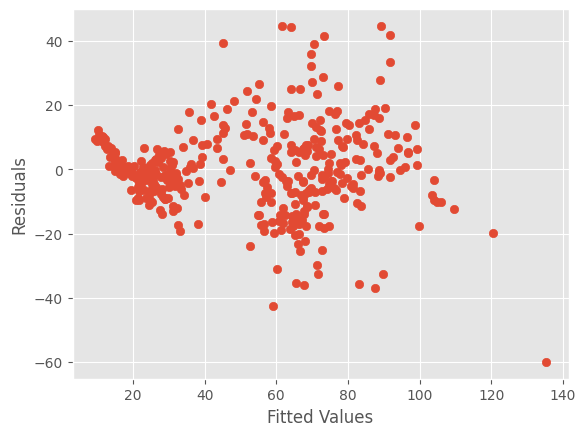

In [47]:
# Plot the fitted values against the residuals
plt.scatter(results.fittedvalues, results.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Linear Regression Conclusions:<br>
Viewing the OLS regression results, the in-sample model results indicate that 79.1% of the oil price variability was captured by the city average, production, and new orders for mining, oil, and gas equipment. To futher confirm the model's fit, the F-statistic's p-value is extremely small leading us to conclude that there is a relationship between the predictors and the response (reject the null hypothesis). Observing the fitted values agains the residuals plot, we can see that there is heteroskedasticity in the error terms.<br><br>
1. The city_average (City Average Price Per kWH) coefficient indicates that a $1 increase in city average price leads to a $169.22 increase price in oil.<br>
2. The prduction (Industrial Production: Electric and Gas) coefficient indicates that a one unit increase in production leads to a $0.69 increase in oil price.<br>
3. The orders_mining_oil_gas (Manufacturer's New Orders: Mining, Oil, Gas) coefficient indicates that a $1 million increase in new orders leads to a $0.02 increase in oil price.<br><br>